# Interpolate SPH particles to a grid in different ways

In [1]:
# load standard python tools
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import sys
import os
import re
import importlib
import swiftsimio

sigma=  1.4607190687030822


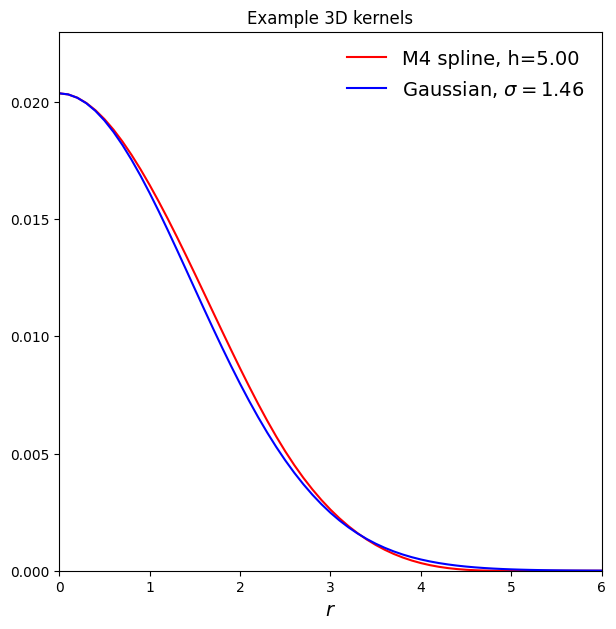

In [2]:
import struct
import copy

class AMR:
    def __init__(self, fpath='./', amr_info_file='amr_grid.inp', lunit = 1.0, verbose=False):

        # unit of length, used for cell sizes
        self.lunit = lunit 
        
        # parse the amr_info_file
        self.fpath         = fpath
        self.amr_info_file = amr_info_file
        self.header        = self.read_amr_header(verbose=verbose)
        self.amr_info      = self.parse_amr_info(os.path.join(self.fpath, self.amr_info_file), verbose=verbose)


    def read_amr_header(self, verbose=False):
        #

        file   = open(os.path.join(self.fpath, self.amr_info_file))
        header = {}
        for i in np.arange(4):
            line = file.readline()
            value = int(line.split()[0])
            if i==0:
                header['1'] = value
            if i==1:
                header['2'] = value
            if i==2:
                header['3'] = value
            if i==3:
                header['4'] = value
        line  = file.readline()
        values = np.array(line.split()[0:3]).astype(int)
        if verbose:
            print('ints: ', values)
        header['ints'] = values
        line  = file.readline()
        nx, ny, nz = np.array(line.split()[0:3]).astype(int)
        if verbose:
            print("basegrid: ", nx, ny, nz)
        header['basegrid'] = [nx, ny, nz]
        line = file.readline()
        nref, ncell, ncellmax = np.array(line.split()[0:3]).astype(int)   
        if verbose:
            print("nref=", nref, ", nel=", ncell,", ncellmax = ", ncellmax)
        #
        header['nref'] = nref
        header['ncell'] = ncell
        header['ncellmax'] = ncellmax
        line  = file.readline()
        xs = np.array(line.split()[0:nx+1]).astype(float)
        if verbose:
            print("xs: ", xs)
        header['xr'] = xs
        line  = file.readline()
        ys = np.array(line.split()[0:ny+1]).astype(float)
        if verbose:
            print("ys: ", ys)
        header['yr'] = ys
        line  = file.readline()
        zs = np.array(line.split()[0:nz+1]).astype(float)
        if verbose:
            print("zs: ", zs)
        header['zr'] = zs
        return header
    
    # read amr_info
    def parse_amr_info(self, amr_info_file, verbose=False):
        # extract the header information
        # extract leaf and node information for a single cell
        
        
        def read_cell(file, refinements = [2, 2, 2], coordinates = [0, 0, 0], level=1, verbose=False):
            #
            line       = file.readline()
            if not line:
                return
            leaf    = int(line)
            counter.append(leaf)
            nl = len(counter)

            cellsize   = 1./2**level
            #
            if leaf == 1:     
                # node
                if verbose:
                    print("node: ", level, cellsize, coordinates)
                cc       = copy.deepcopy(coordinates)
                lev      = copy.deepcopy(level)
                lev     += 1
                cellsize = 1./2**lev
                #print('coordinates, cellsize ', cc, cellsize)
                #
                for iz in range(refinements[2]):
                    cc[2]     = coordinates[2] + iz * cellsize
                    for iy in range(refinements[1]):
                        cc[1]   = coordinates[1] + iy * cellsize
                        for ix in range(refinements[0]):
                            cc[0]          = coordinates[0] + ix * cellsize
                            nn             = read_cell(file, refinements=refinements, coordinates=cc, level=lev, verbose=verbose)
                            nodes_grid[nl] = {'level':lev, 'pos': cc, 'cellsize': cellsize}
                return 0
            else: 
                cc              = copy.deepcopy(coordinates)
                lev             = copy.deepcopy(level)
                leaves_grid[nl] = {'level':lev, 'pos': cc, 'cellsize': cellsize}
                return 1

        
        # extract info from amr file
        
        # read header and leaf/node info for the full amr grid
        
        # step 1: read the header info
        header      = self.header
        
        # step 2: extract refinement levels from header
        basegrid = header['basegrid']
        if verbose:
            print("basegrids = ", basegrid)
        
        # step 3: open file and skip header information
        amr_file  = open(amr_info_file)
        for i in np.arange(10):
            line = amr_file.readline()

        # step 4: set parameters of the base mesh
        # set level of the base mesh
        base_level  = 1

        # set cell size of the base grid refinements in as a fraction of the box
        cellsize    = 1./2**base_level

        # set coordinates of the leaf or node (lower left corner) as a fraction of the box
        coordinates = [0, 0, 0]
        
        # step 5: loop over the cells on the base mesh
        leaves_grid  = {}   # contains information of the leaves
        nodes_grid   = {}   # contains information of the nodes
        counter      = []   # counter
        for iz in range(basegrid[2]):
            coordinates[2] = iz * cellsize
            for iy in np.arange(basegrid[1]):
                coordinates[1] = iy * cellsize
                for ix in np.arange(basegrid[0]):
                    coordinates[0] = ix * cellsize
                    #
                    level  = copy.deepcopy(base_level)
                    read_cell(amr_file, refinements=[2, 2, 2], 
                              coordinates = coordinates, level=level, verbose=verbose)
        amr_file.close()

        # determine the highest level of refinement
        maxlevel = -1
        for i, leaf in enumerate(leaves_grid):
            level = leaves_grid[leaf]['level']
            if level > maxlevel:
                maxlevel = level
                print('maxlevel', maxlevel)
        
        # return the information
        return {'header':header, 'leaves':leaves_grid, 'nodes':nodes_grid, 'maxlevel':maxlevel}


    def read_amr_var(self, infile='gas_temperature.binp', verbose=False):
        bin_file = open(os.path.join(self.fpath, infile), 'rb')

        # read header info
        buf = bin_file.read(24)
        iformat, precis, nrcells = struct.unpack("3l", buf)
        if verbose:
            print("format = {0:1d}, precision={1:1d}, nrcells={2:1d}".format(iformat, precis, nrcells))
        vals = []
        for i in range(nrcells):
            vals.append(struct.unpack("d", bin_file.read(precis)))
        bin_file.close()
        vals = np.array(vals)
        return {'values':vals, 'precision':precis, 'format':iformat, 'nrcells':nrcells}
    
    def write_amr_var(self, info, outfile='level.binp', verbose=False):
        bin_file = open(os.path.join(self.fpath, outfile), 'wb')

        # write header info
        if verbose:
            print("format = {}".format(info['format']))
            print("precision = {}".format(info['precision']))
            print("nrcells = {}".format(info['nrcells']))
        buf = struct.pack("3l", info['format'], info['precision'], info['nrcells'])
        bin_file.write(buf)

        # write data
        if len(info['values']) != info['nrcells']:
            print("Error in write_amr: sizes tdo not match, len={}, nrcells={}".format(len(info['values']), info['nrcells']))
        for value in info['values']:
            buf = struct.pack("d", value)
            bin_file.write(buf) 
        bin_file.close()
    
#     def write_amr_var_v2(self, info, outfile='level.binp', verbose=False):
#         bin_file = open(outfile, 'wb')

#         # write header info
#         if verbose:
#             print("format = {}".format(info['format']))
#             print("precision = {}".format(info['precision']))
#             print("nrcells = {}".format(info['nrcells']))
#         buf = struct.pack("3l", info['format'], info['precision'], info['nrcells'])
#         bin_file.write(buf)

#         # write data
#         if len(info['values']) != info['nrcells']:
#             print("Error in write_amr: sizes tdo not match, len={}, nrcells={}".format(len(info['values']), info['nrcells']))
#         for value in info['values']:
#             buf = struct.pack("d", value)
#             bin_file.write(buf) 
#         bin_file.close()
        
    def uniform_mesh(self, variable_info):
        '''
        interpolate variable to uniform mesh
        input: variable_info
              this is what read_amr_var returns
    
        '''

        #
        variable = variable_info['values']
        nrcells  = variable_info['nrcells']
        
        #
        maxlevel = self.amr_info['maxlevel']
        leaves   = self.amr_info['leaves']
        nleaves  = len(leaves)
        if len(leaves) != nrcells:
            print("Error, sizes do not match, nrcells {}, nrleaves = {}".format(nrcells, nleaves))
        
        # create uniform mesh
        header   = self.header # otherwise the header var in the next line is not defined 
        nuni     = 2**(maxlevel-1) * header['basegrid'][0]
        mesh     = np.zeros((nuni, nuni, nuni))
        varmesh  = np.zeros((nuni, nuni, nuni))
    
        
        # store leave coordinates and variable value for each level
        for level in np.arange(1, maxlevel+1):
            xl     = []
            yl     = []
            zl     = []
            cc     = []
            amrvar = []
            for i, leaf in enumerate(leaves):
                    lev   = leaves[leaf]['level']
                    pos   = leaves[leaf]['pos']
                    cell  = leaves[leaf]['cellsize']
                    if lev == level:
                        xl.append(pos[0])
                        yl.append(pos[1])
                        zl.append(pos[2])
                        cc.append(cell)
                        amrvar.append(variable[i])
            xl = np.array(xl)
            yl = np.array(yl)
            zl = np.array(zl)
            cc = np.array(cc)
            for var in variables:
                amrvar = np.array(amrvar).reshape(-1)

            # integer coordinates on current mesh
            ixl = (xl / cc).astype(int)
            iyl = (yl / cc).astype(int)
            izl = (zl / cc).astype(int)

            # integer coordinates on uniform mesh
            levmax = maxlevel
            f    = int(2**(levmax-level))
            ixl *= f
            iyl *= f
            izl *= f

            # set refinement mesh
            for diz in np.arange(0,f):
                for diy in np.arange(0,f):
                    for dix in np.arange(0,f):
                        mesh[ixl+dix, iyl+diy, izl+diz] = level

            # set value of variable on the mesh
            if len(amrvar) > 0:
                values = np.array(amrvar)
                for diz in np.arange(0,f):
                    for diy in np.arange(0,f):
                        for dix in np.arange(0,f):
                            varmesh[ixl+dix, iyl+diy, izl+diz] = values
        #
        return {'level':mesh, 'variable':varmesh}


# run the analysis

class Kernels:
    def __init__(self):
        self.ndim=3

    def M4spline(self, r=np.arange(0, 1, 0.1), h=1.0):
        '''
        M4 spline interpolation kernel, which has M4spline= when q=r/h>1
        input:
            r: distance from origin
            h: smoothing length
        '''
        w = np.zeros_like(r)
        q = r / h

        mask = q <= 1 / 2
        w[mask] = (1 - 6 * q[mask]**2 + 6 * q[mask]**3)
        mask = (q > 1 / 2.) & (q < 1)
        w[mask] = 2 * (1. - q[mask])**3
        w *= 8 / (np.pi * h**3)
        return w

    def GaussFWHM(self, h=1.0):
        '''Returns value of dispersion for which FWHM is the same
           as for an M4 spline with given value of smoothing length, h'''
        return (1. - (1. / 4.)**(1. / 3)) / np.sqrt(2 * np.log(2)) * h

    def GaussPeak(self, h=1.0):
        '''Returns value of dispersion for which peak value (at r=0) is the same
           as for an M4 spline with given value of smoothing length, h'''
        return 1. / np.sqrt(2 * np.pi) * (np.pi / 8)**(1. / 3.) * h
    
    def Gauss(self, r=np.arange(0, 1, 0.1), h=1.0):
        ''' Return normalized Gaussian with given smoothing length'''
        sigma  = self.GaussPeak(h=h)
        g      = np.exp(-r**2/(2*sigma**2))
        norm   = 1./(2*np.pi*sigma**2)**(3./2.)
        return g*norm

    def ShowKernel(self, ax=None):
        r     = np.array(np.arange(0, 10, 0.1))
        h     = 5.0
        m4    = self.M4spline(r=r, h=h)
        sigma = self.GaussPeak(h)
        print("sigma= ", sigma)
        gauss = self.Gauss(r=r, h=h)
        #
        fontsize=14
        if ax==None:
            fig, ax = plt.subplots(1, 1, figsize = (7, 7))
        ax.plot(r, m4, color='red', label=r'M4 spline, h={0:1.2f}'.format(h))
        ax.plot(r, gauss, color='blue', label=r'Gaussian, $\sigma=${0:1.2f}'.format(sigma))
        ax.set_xlim(0, 6.0)
        ax.set_ylim(0, 0.023)
        ax.set_xlabel(r'$r$', fontsize=fontsize)
        ax.set_title("Example 3D kernels")
        ax.legend(frameon=False, fontsize=fontsize)
        if ax==None:
            fig.show()
kernel = Kernels()
kernel.ShowKernel()

In [54]:
kernel =  Kernels()

class SPH2Grid:
    def __init__(self, nx=32, ny=32, nz=32, zrange = None, periodic=True, boxlen=1.0):
        # grid parameters
        self.nx       = nx
        self.ny       = ny
        self.nz       = nz
        self.cell     = boxlen / nx
        self.periodic = periodic
        self.boxlen   = boxlen
        self.zrange   = zrange
        #
        self.grid = self.CreateGrid()

    def NGP(self, x=0.0, y=0.0, z=0.0, weight=1.0, periodic=True):
        #
        dx = self.Periodic(x - self.grid['xgrid'])
        dy = self.Periodic(y - self.grid['ygrid'])
        dz = self.Periodic(z - self.grid['zgrid'])
        dr = np.sqrt(dx**2 + dy**2 + dz**2)
        #
        drmin  = np.min(dr)
        mask   = dr <= drmin
        ncells = np.sum(mask)
        #
        self.grid['density'][mask] += weight / ncells
        
    def M4Spline(self, x=0.0, y=0.0, z=0.0, weight=1.0, h = 1.0, periodic=True):
        dx     = self.Periodic(x - self.grid['xgrid'])
        dy     = self.Periodic(y - self.grid['ygrid'])
        dz     = self.Periodic(z - self.grid['zgrid'])
        dr     = np.sqrt(dx**2 + dy**2 + dz**2)
        sph    = kernel.M4spline(r=dr, h=h)
        self.grid['density'] += sph * weight

    def Periodic(self, dx):
        # impose periodic boundary conditions
        if self.periodic:
            dx[dx < -0.5*self.boxlen] += self.boxlen
            dx[dx >  0.5*self.boxlen] -= self.boxlen
        return dx
        
    def CreateGrid(self):
        #        
        xvals    = (np.arange(self.nx) + 0.5) *  self.cell
        yvals    = (np.arange(self.ny) + 0.5) *  self.cell
        zvals    = (np.arange(self.nz) + 0.5) *  self.cell

        if self.zrange is not None:
            zvals   = zvals[(zvals >= self.zrange[0]) & (zvals <= self.zrange[1])]
            self.nz = len(zvals)
        
        #
        xgrid, ygrid, zgrid = np.meshgrid(xvals, yvals, zvals)
        density  = np.zeros((self.nx, self.ny, self.nz), dtype=float)
        
        return {'density':density, 'xgrid':xgrid, 'ygrid':ygrid, 'zgrid':zgrid, 'xvals':xvals, 'yvals':yvals, 'zvals':zvals}


sph2grid = SPH2Grid(nx=32, ny=32, nz=32, periodic=True, boxlen=1.0, zrange=zrange)
grid     = sph2grid.CreateGrid()




cell size = 0.03125
total mass on grid = 20.999999670804094, in particles = 21.0


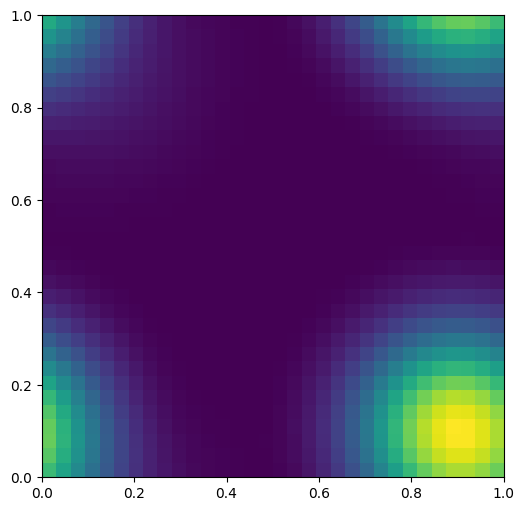

In [64]:
# Example
boxlen   = 1.0
zrange   = [0.2, 0.8]
sph2grid = SPH2Grid(nx=32, ny=32, nz=32, periodic=True, boxlen=boxlen, zrange=None)
grid     = sph2grid.CreateGrid()

# create some particles
xs = np.array([0.1, 0.9])
ys = np.array([0.1, 0.9])
zs = np.array([0.1, 0.9])
hs = np.array([0.5, 0.5]) # smoothing must be larger than cell size, e.g., 3 times the cellsize
ws = np.array([1.0, 20.0]) # think of it as mass

# sph2grid.NGP(x=x, y=y, z=z, weight=w)
for x, y, z, h, w in zip(xs, ys, zs, hs, ws):
    sph2grid.M4Spline(x=x, y=y, z=z, h=h, weight=w)
grid = sph2grid.grid
cell = sph2grid.cell
print("cell size = {}".format(cell))
print("total mass on grid = {}, in particles = {}".format(np.sum(grid['density']) * cell**3, np.sum(ws)))

# plot the grid
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

xextent=[sph2grid.grid['xvals'][0]-sph2grid.cell/2, sph2grid.grid['xvals'][-1]+sph2grid.cell/2]
yextent=[sph2grid.grid['yvals'][0]-sph2grid.cell/2, sph2grid.grid['yvals'][-1]+sph2grid.cell/2]
extent = np.concatenate((xextent, yextent))

ax.imshow(sph2grid.grid['density'][:, :, 2], extent=extent, aspect='equal')
ax.set_xlim(xextent[0], xextent[1])
ax.set_ylim(yextent[0], yextent[1])

fig.show()


# Read in swift snapshot and extract particles within a given slice

In [67]:
fdir  = '/cosma/home/dp004/dc-liu3/data7/sims/swift-rt/YuanKangLiu_snapshots/RadBound_turb/T3e4/'
fname = 'output_Radbound_0047.hdf5'
snap = swiftsimio.load(os.path.join(fdir, fname))

# now read all particles
npart = len(snap.gas.masses.in_units('Msun').value) # number of particles
print("Number of particles = {}".format(npart))

#
boxlen =  snap.metadata.boxsize.in_units('pc').value[0] # pc
print("Boxlen = {}".format(boxlen))

header = {'boxlen':boxlen}

# extract desired information
allparts = {'xs':snap.gas.coordinates.in_units('pc').value[:, 0],
         'ys':snap.gas.coordinates.in_units('pc').value[:, 1],
         'zs':snap.gas.coordinates.in_units('pc').value[:, 2],
         'hs':snap.gas.smoothing_lengths.in_units('pc').value,
        'ws':snap.gas.masses.in_units('Msun').value,
        'ds':snap.gas.densities.in_units('Msun / pc**3').value}

Number of particles = 2097152
Boxlen = 1.000000000311868


In [73]:
# z-range - in units of the box size
zrange = np.array([0.499, 0.501]) * boxlen

# find the mask
mask = (allparts['zs'] + allparts['hs'] >= zrange[0]) & ((allparts['zs'] - allparts['hs'] < zrange[1]))
print("number of particles selected = {}".format(np.sum(mask)))

parts = {}
for key in allparts.keys():
    parts[key] = allparts[key][mask]

number of particles selected = 36406


# Create grid and interpolate particles to grid in parallel

cell size = 0.03125000000974588
total mass on grid = 0.0014493620689376386, in particles = 0.027886807918548584
CPU times: user 2.98 s, sys: 7.81 ms, total: 2.99 s
Wall time: 3.01 s


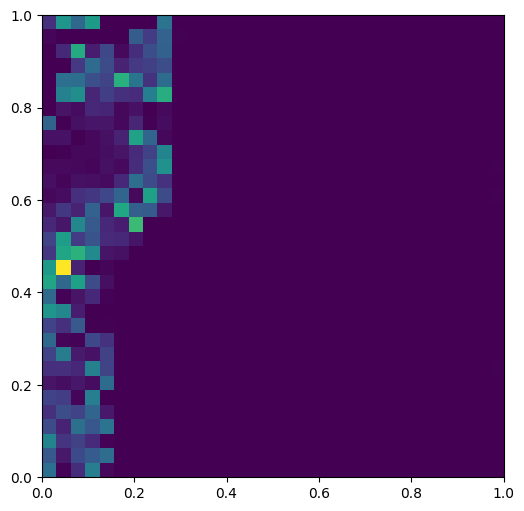

In [80]:
%%time
# serial example
npixel   = 32
sph2grid = SPH2Grid(nx=npixel, ny=npixel, nz=npixel, boxlen=boxlen, periodic=True, zrange=None)
cell     = sph2grid.cell

#

for i, (x, y, z, h, w) in enumerate(zip(parts["xs"], parts["ys"], parts["zs"], parts["hs"], parts["ws"])):
    if i < 5000:
        sph2grid.M4Spline(x=x, y=y, z=z, h=h, weight=w)

grid = sph2grid.grid
print("cell size = {}".format(cell))
print("total mass on grid = {}, in particles = {}".format(np.sum(grid['density']) * cell**3, np.sum(parts["ws"])))

# plot the grid
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

xextent=[sph2grid.grid['xvals'][0]-sph2grid.cell/2, sph2grid.grid['xvals'][-1]+sph2grid.cell/2]
yextent=[sph2grid.grid['yvals'][0]-sph2grid.cell/2, sph2grid.grid['yvals'][-1]+sph2grid.cell/2]
extent = np.concatenate((xextent, yextent))

ax.imshow(np.sum(sph2grid.grid['density'][:, :, :], axis=2), extent=extent, aspect='equal')
ax.set_xlim(xextent[0], xextent[1])
ax.set_ylim(yextent[0], yextent[1])

fig.show()



In [98]:
print(1+1)

2


In [ ]:
# parallel example
import multiprocessing
from multiprocessing import Pool

npixel   = 32
periodic = True
zrange   = None
sph2grid = SPH2Grid(nx=npixel, ny=npixel, nz=npixel, boxlen=boxlen, periodic=periodic, zrange=zrange)
cell     = sph2grid.cell
#
ncpu     = 2      # number of cores to be used
pool     = multiprocessing.Pool(ncpu)
manager  = multiprocessing.Manager()
results  = manager.dict()


def do_project(i, ncpu, npixel, boxlen, periodic, zrange, parts, results):
    sph2grid = SPH2Grid(nx=npixel, ny=npixel, nz=npixel, boxlen=boxlen, periodic=periodic, zrange=zrange)
    nparts   = len(parts["xs"])
    indx     = np.arange(nparts)
    nmean    = int(nparts/ncpu)
    mask     = (indx >= i * nmean) & (indx < (i+1) * nmean)
    indx     = indx[mask]
    #    
    for j, (x, y, z, h, w ) in enumerate(zip(parts["xs"][mask], parts["ys"][mask], parts["zs"][mask], parts["hs"][mask], parts["ws"][mask])):    
        if j < 10:
            sph2grid.M4Spline(x=x, y=y, z=z, h=h, weight=w)
    #
    result     = {'nproc':indx, 'density':sph2grid.grid["density"]}
    results[i] = result
    
for i in np.arange(ncpu):
    print("i=", i)
    pool.apply_async(do_project, args=(i, ncpu, npixel, boxlen, periodic, zrange, parts, results))
    
pool.close()
pool.join()
print("Calculation finished!")                     

indx = []
rho  = np.zeros_like(results[0]['density'])
for i in np.arange(ncpu):
    # print(i, results[i]['nproc'])
    indx.append(results[i]['nproc'])
    # print(i, results[i]['density'])
    rho += results[i]['density']
print(indx)

print("cell size = {}".format(cell))
print("total mass on grid = {}, in particles = {}".format(np.sum(rho) * cell**3, np.sum(parts["ws"])))

# # plot the grid
# fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# xextent=[sph2grid.grid['xvals'][0]-sph2grid.cell/2, sph2grid.grid['xvals'][-1]+sph2grid.cell/2]
# yextent=[sph2grid.grid['yvals'][0]-sph2grid.cell/2, sph2grid.grid['yvals'][-1]+sph2grid.cell/2]
# extent = np.concatenate((xextent, yextent))

# ax.imshow(np.sum(sph2grid.grid['density'][:, :, :], axis=2), extent=extent, aspect='equal')
# ax.set_xlim(xextent[0], xextent[1])
# ax.set_ylim(yextent[0], yextent[1])

# fig.show()

i= 0
i= 1
Calculation finished!
[array([    0,     1,     2, ..., 18200, 18201, 18202]), array([18203, 18204, 18205, ..., 36403, 36404, 36405])]
cell size = 0.03125000000974588
total mass on grid = 2.7226115116357964e-06, in particles = 0.027886807918548584


In [136]:
print(sph2grid.grid["density"].shape)

(32, 32, 32)


In [14]:
%%time
for x, y, z, h, w in zip(xs, ys, zs, hs, ws):
    sph2grid.M4Spline(x=x, y=y, z=z, h=h, weight=w)
grid = sph2grid.grid

print(np.sum(grid['density']))

379336.6275895946
CPU times: user 2min 52s, sys: 1min 37s, total: 4min 29s
Wall time: 4min 30s


In [16]:
max(grid['density'].ravel())

np.float64(150.06459234035492)

### Parellel version

In [86]:
%%time

from multiprocessing import Pool

ncpu   = 25      # number of cores to be used
    #    
pool      = multiprocessing.Pool(ncpu)
manager   = multiprocessing.Manager()
density   = manager.dict()

xs = SightCoords['x']
ys = SightCoords['y']
for i, (x,y) in enumerate(zip(xs, ys)):
    pool.apply_async(do_sight, args=(i, x, y, projections))
    density[i] = sph2grid.grid
    
pool.close()
pool.join()
print("Calculation finished!")


def map_particle_to_grid(args):
    x, y, z, h, w, grid_params = args
    sph2grid = SPH2Grid_zslice(**grid_params)
    sph2grid.M4Spline(x=x, y=y, z=z, h=h, weight=w)
    #print(sph2grid.grid['density'].shape)
    return sph2grid.grid['density']

# Grid configuration
grid_params = {
    'nx': 32, 'ny': 32, 'nz': 32,
    'cell': cellsize,
    'periodic': True,
    'period': 32,
    'zrange': (2, 10)
}

input_list = list(zip(xs, ys, zs, hs, ws, [grid_params] * len(xs)))

with Pool(processes=4) as pool:
    densities = pool.map(map_particle_to_grid, input_list)

#print(np.array(densities))

# Combine densities
total_density = np.sum(densities)

# combined result
sph2grid = SPH2Grid_zslice(**grid_params)
sph2grid.grid['density'] = densities
grid = sph2grid.grid

NameError: name 'SightCoords' is not defined

In [27]:
np.sum(grid['density'])

np.float64(0.0)

In [18]:
print(max(grid['density'].ravel()))
print(np.sum(grid['density']*cellsize**3))

379336.6275895917
0.00282627811986581


In [382]:
print(np.sum(grid['density']*cellsize**3))
print(np.sum(ws))

0.0028262781198658336
0.003409444


In [383]:
np.min(colors)

np.float32(0.085226916)

/tmp/ipykernel_359632/1834064764.py:9: RuntimeWarning: divide by zero encountered in log10
  proj = (np.log10(grid2D) - dmin) / (dmax - dmin)


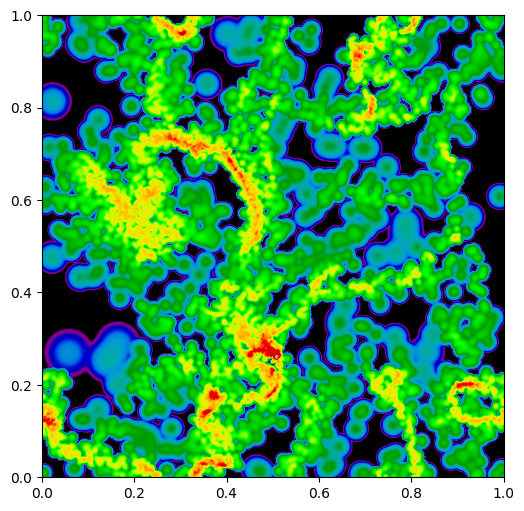

In [388]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))


#grid2D = np.sum(sph2grid.grid['density'], axis=2) * cellsize
grid2D = np.max(sph2grid.grid['density'], axis=2)

dmin = -4
dmax = 3
proj = (np.log10(grid2D) - dmin) / (dmax - dmin)
proj[proj < 0] = 0
proj[proj >= 1] = 1

xextent=[sph2grid.grid['xvals'][0]-sph2grid.cell/2, sph2grid.grid['xvals'][-1]+sph2grid.cell/2]
yextent=[sph2grid.grid['yvals'][0]-sph2grid.cell/2, sph2grid.grid['yvals'][-1]+sph2grid.cell/2]
extent = np.concatenate((xextent, yextent))

ax.imshow(proj, origin='lower', extent=extent, aspect='equal',cmap='nipy_spectral')
ax.set_xlim(xextent[0], xextent[1])
ax.set_ylim(yextent[0], yextent[1])

fig.show()

In [332]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
print(list(colormaps))
ncolors = 256
#cmap = LinearSegmentedColormap.from_list('rb', ['r', 'w', 'g'], N=ncolors)

cmap = colormaps['nipy_spectral']

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

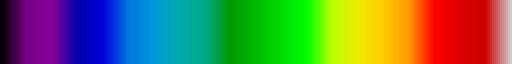

In [334]:
cmap(0.1)

(np.float64(0.5306882352941177),
 np.float64(0.0),
 np.float64(0.5973843137254902),
 np.float64(1.0))

In [350]:

colors = (np.log10(ds) - dmin) / (dmax - dmin) / ncolors
print(colors)

[0.00145006 0.00185237 0.00200511 ... 0.00169144 0.00147603 0.00161118]


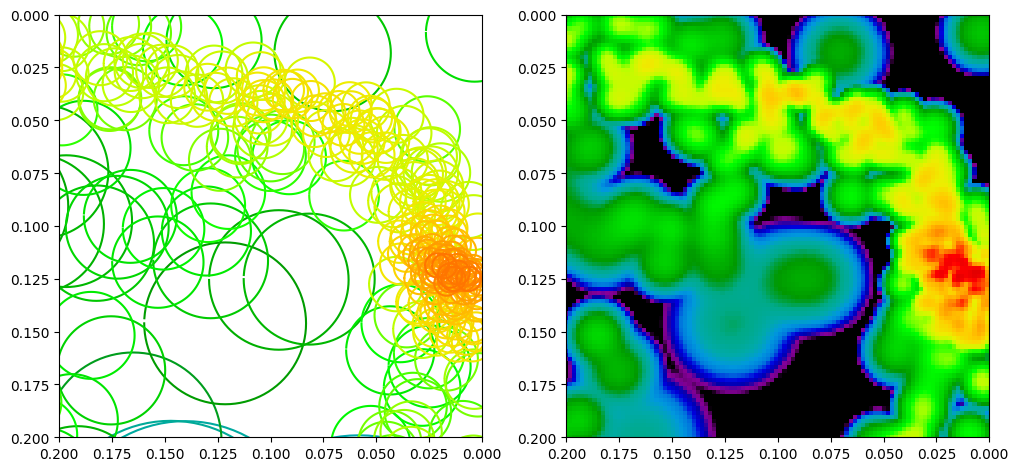

In [389]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

def Circle(x, y, h, w):
    nbins = 100
    phi = np.arange(0, nbins) / nbins * 2 * np.pi
    xp = x + h * np.cos(phi)
    yp = y + h * np.sin(phi)
    return xp, yp

dmin = -4
dmax = 3
colors = (np.log10(ds) - dmin) / (dmax - dmin)
colors[colors < 0] = 0
colors[colors >= 1] = 1

ind = np.argsort(colors)

for x, y, z, h, w, color in zip(xs[ind], ys[ind], zs[ind], hs[ind], ws[ind], colors[ind]):
    xp, yp = Circle(x, y, h, w)
    im1 = ax[0].plot(xp, yp, color=cmap(color))

im2 = ax[1].imshow(proj, origin='lower', extent=extent, aspect='equal',cmap='nipy_spectral')

xrange = [0.2, 0,4]
yrange = [0.2, 0,4]


for i in np.arange(2):
    ax[i].set_aspect('equal')

    ax[i].set_xlim(xrange[0], xrange[1])
    ax[i].set_ylim(yrange[0], yrange[1])

fig.show()

/tmp/ipykernel_359632/2590383062.py:11: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(xg[mask], np.log10(dg[mask]), marker='+', linestyle='none', color='r')


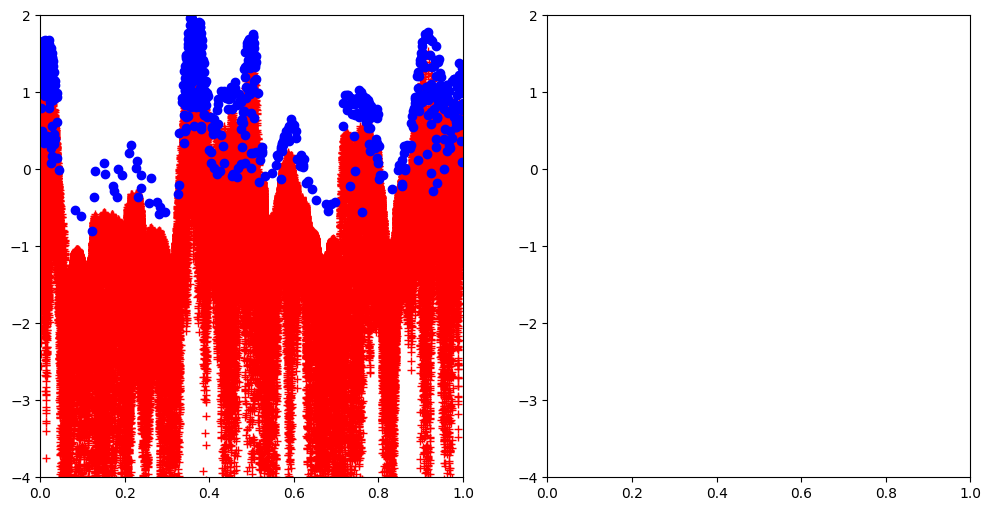

In [393]:
yrange = [0.1, 0.2]

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

xg = grid['xgrid']
yg = grid['ygrid']
zg = grid['zgrid']
dg = grid['density']

mask = ((yg > yrange[0]) & (yg < yrange[1]))
ax[0].plot(xg[mask], np.log10(dg[mask]), marker='+', linestyle='none', color='r')

mask = (ys > yrange[0]) & (ys < yrange[1])

ax[0].plot(xs[mask], np.log10(ds[mask]), marker='o', linestyle='none', color='b')

for i in np.arange(2):
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(-4, 2)

fig.show()

/tmp/ipykernel_359632/641266757.py:9: RuntimeWarning: divide by zero encountered in log10
  pdf, pdfbins = np.histogram(np.log10(dg), bins=bins, density=True)


9.999999999999993
9.995662


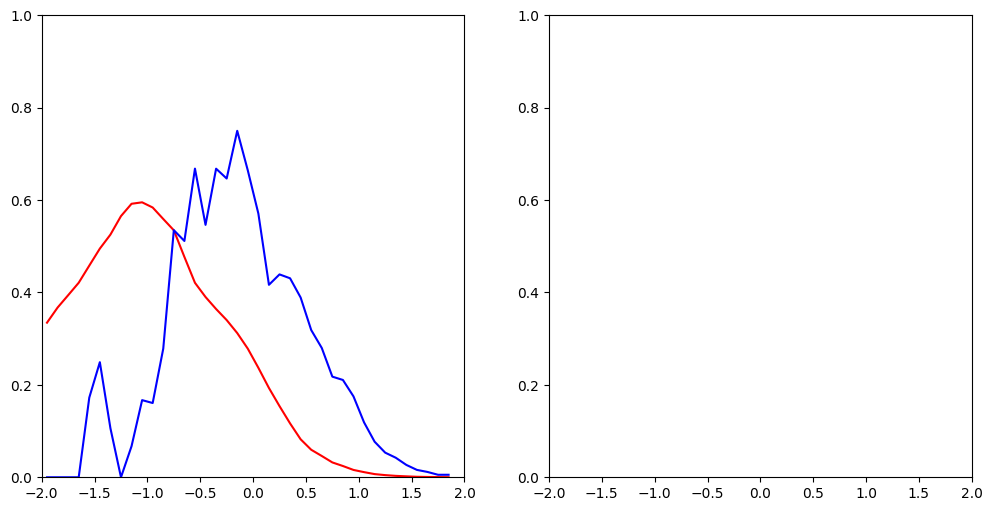

In [402]:
## pdf of density distribution (volume-weighted)
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
## grid
dmin = -2
dmax = 2
dbin = 0.1
bins = np.arange(dmin, dmax, dbin)

pdf, pdfbins = np.histogram(np.log10(dg), bins=bins, density=True)
binc = 0.5 * (pdfbins[0:-1] + pdfbins[1:])
print(np.sum(pdf))

pdfpart = []
rinv = 1 / ds
rlog = np.log10(ds)
for left, right in zip(pdfbins[:-1], pdfbins[1:]):
    mask = (rlog > left) & (rlog <= right)
    pdfpart.append(np.sum(rinv[mask]))

pdfpart = (pdfpart / np.sum(rinv)) / dbin
print(np.sum(pdfpart))
ax[0].plot(binc, pdf, color='r')
ax[0].plot(binc, pdfpart, color='b')

for i in np.arange(2):
    ax[i].set_xlim(dmin, dmax)
    ax[i].set_ylim(0, 1)

In [405]:
fpath = '/cosma/home/dp004/dc-liu3/data7/sims/swift-rt/YuanKangLiu_snapshots/radmc3d_RadBound_turb_slices/radmc3d_RadBound_turb_z_0.498_0.500'

amr = AMR(fpath=fpath, amr_info_file='amr_grid.inp', verbose=False)

# read all variables
variables = ['T', 'ne', 'nHII', 'nHI']
T_file    = 'gas_temperature_HII.binp'
ne_file   = 'numberdens_elec.binp'
nHII_file = 'numberdens_HII.binp'
nHI_file  = 'numberdens_HI.binp'
data      = {}
for i, (variable, file) in enumerate(zip(variables, [T_file, ne_file, nHII_file, nHI_file])):
    print("reading ", variable, "from file = ", file)
    info = amr.read_amr_var(infile=file, verbose=(i==0))
    data[variable] = info['values']
nH = data['nHI'] + data['nHII']

maxlevel 1
maxlevel 2
maxlevel 3
maxlevel 4
maxlevel 5
maxlevel 6
maxlevel 7
maxlevel 8
reading  T from file =  gas_temperature_HII.binp
format = 1, precision=8, nrcells=5951
reading  ne from file =  numberdens_elec.binp
reading  nHII from file =  numberdens_HII.binp
reading  nHI from file =  numberdens_HI.binp


In [408]:
%%time
nHIImesh    = amr.uniform_mesh(amr.read_amr_var(infile=nHII_file, verbose=False))
nHImesh    = amr.uniform_mesh(amr.read_amr_var(infile=nHI_file, verbose=False))

nHtot = nHImesh['variable'] + nHIImesh['variable']

CPU times: user 2min, sys: 1.02 s, total: 2min 1s
Wall time: 2min 1s


In [455]:
import unyt
rho_amr = (nHIImesh['variable'] * unyt.cm**(-3) * unyt.hydrogen_mass).in_units('Msun / pc**3').value

In [456]:
rho_amr.shape

(512, 512, 512)

In [420]:
print(max(rho_amr.ravel()))

199.66667116130915


/tmp/ipykernel_359632/3120502286.py:10: RuntimeWarning: divide by zero encountered in log10
  proj = (np.log10(grid2D) - dmin) / (dmax - dmin)
/tmp/ipykernel_359632/3120502286.py:23: RuntimeWarning: divide by zero encountered in log10
  proj = (np.log10(grid2D_amr) - dmin) / (dmax - dmin)


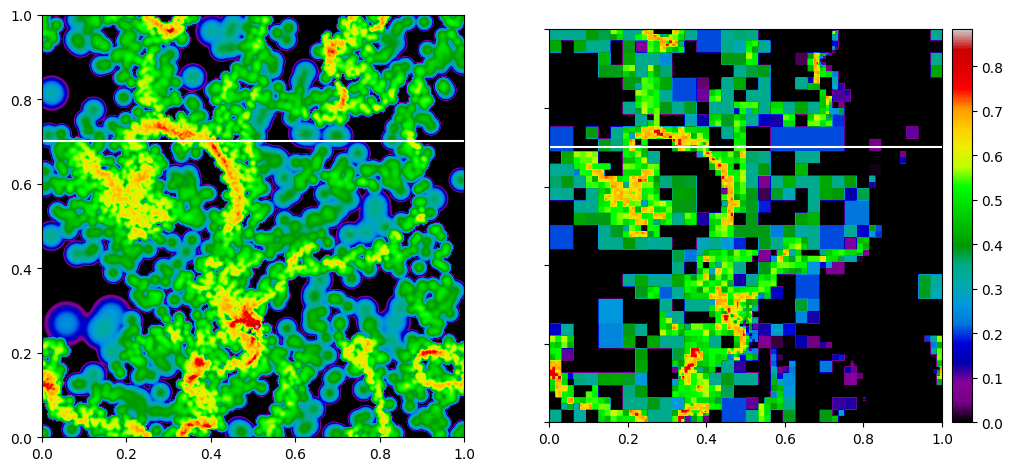

In [457]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey=True)

#grid2D = np.sum(sph2grid.grid['density'], axis=2) * cellsize
grid2D = np.max(sph2grid.grid['density'], axis=2)

dmin = -4
dmax = 3

# scaling to 0 - 1
proj = (np.log10(grid2D) - dmin) / (dmax - dmin)
proj[proj < 0] = 0
proj[proj >= 1] = 1

xextent=[sph2grid.grid['xvals'][0]-sph2grid.cell/2, sph2grid.grid['xvals'][-1]+sph2grid.cell/2]
yextent=[sph2grid.grid['yvals'][0]-sph2grid.cell/2, sph2grid.grid['yvals'][-1]+sph2grid.cell/2]
extent = np.concatenate((xextent, yextent))

im0 = ax[0].imshow(proj, origin='lower', extent=extent, aspect='equal',cmap='nipy_spectral')


grid2D_amr = np.max(rho_amr, axis=2)

proj = (np.log10(grid2D_amr) - dmin) / (dmax - dmin)
proj[proj < 0] = 0
proj[proj >= 1] = 1

ax[1].imshow(proj.T, origin='lower', extent=extent, aspect='equal',cmap='nipy_spectral')

y = 0.7

for i in np.arange(2):
    ax[i].set_xlim(xextent[0], xextent[1])
    ax[i].set_ylim(yextent[0], yextent[1])
    ax[i].axhline(y=y, color='white')


ax[0].set_title('Regular Grid')
ax[1].set_title('AMR Grid')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5 %', pad=0.1)

fig.colorbar(im0, cax=cax)

fig.show()

/tmp/ipykernel_359632/3465034631.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.plot(gridx, np.log10(grid2D[:, ypixel]), color='b')
/tmp/ipykernel_359632/3465034631.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(gridx, np.log10(grid2D_amr.T[:, ypixel]), color='r')


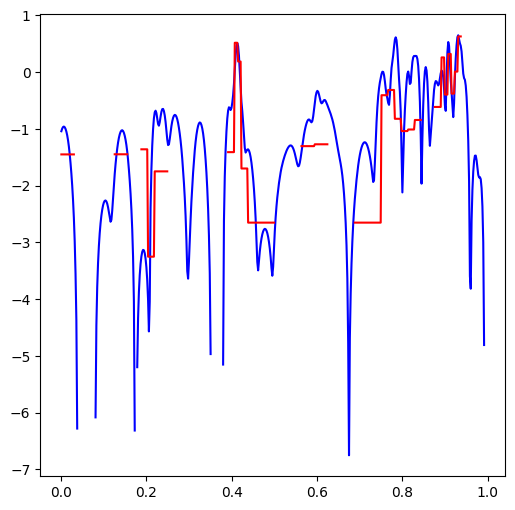

In [438]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

zpixel = 256
ypixel = int(y * 512)
gridx = grid['xvals']

ax.plot(gridx, np.log10(grid2D[:, ypixel]), color='b')
ax.plot(gridx, np.log10(grid2D_amr.T[:, ypixel]), color='r')


/tmp/ipykernel_359632/4103467776.py:8: RuntimeWarning: divide by zero encountered in log10
  pdf, pdfbins = np.histogram(np.log10(dg), bins=bins, density=True)
/tmp/ipykernel_359632/4103467776.py:26: RuntimeWarning: divide by zero encountered in log10
  pdf_amr, pdfbins = np.histogram(np.log10(grid2D_amr), bins=bins, density=True)


9.999999999999993
9.995662


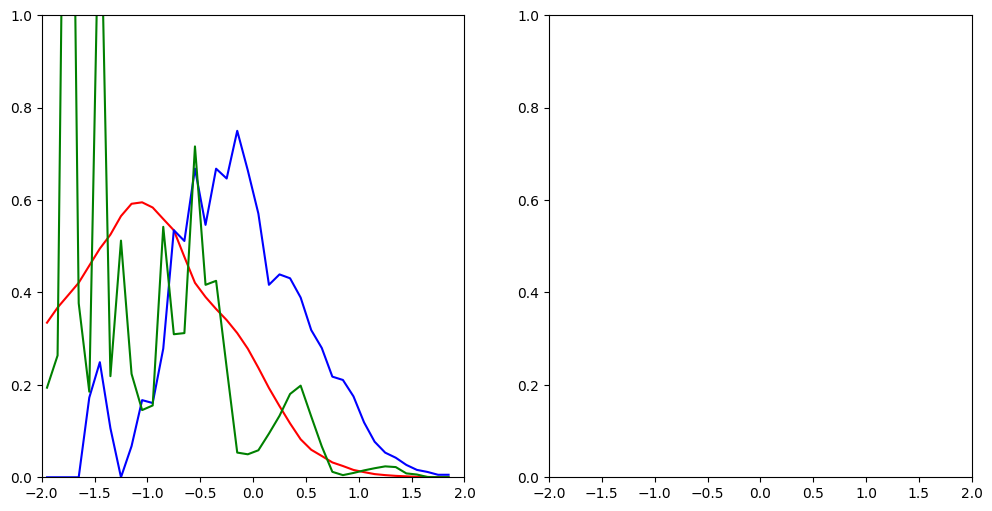

In [440]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
## grid
dmin = -2
dmax = 2
dbin = 0.1
bins = np.arange(dmin, dmax, dbin)

pdf, pdfbins = np.histogram(np.log10(dg), bins=bins, density=True)
binc = 0.5 * (pdfbins[0:-1] + pdfbins[1:])
print(np.sum(pdf))

pdfpart = []
rinv = 1 / ds
rlog = np.log10(ds)
for left, right in zip(pdfbins[:-1], pdfbins[1:]):
    mask = (rlog > left) & (rlog <= right)
    pdfpart.append(np.sum(rinv[mask]))

pdfpart = (pdfpart / np.sum(rinv)) / dbin
print(np.sum(pdfpart))
ax[0].plot(binc, pdf, color='r', label='regular grid')
ax[0].plot(binc, pdfpart, color='b', label='particle')

# pdf from amr grid

pdf_amr, pdfbins = np.histogram(np.log10(grid2D_amr), bins=bins, density=True)

ax[0].plot(binc, pdf_amr, color='g', )

for i in np.arange(2):
    ax[i].set_xlim(dmin, dmax)
    ax[i].set_ylim(0, 1)

0.019999999999999997
0.019999998


/tmp/ipykernel_359632/4059857728.py:28: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(binc, np.log10(pdf_amr), color='g', )


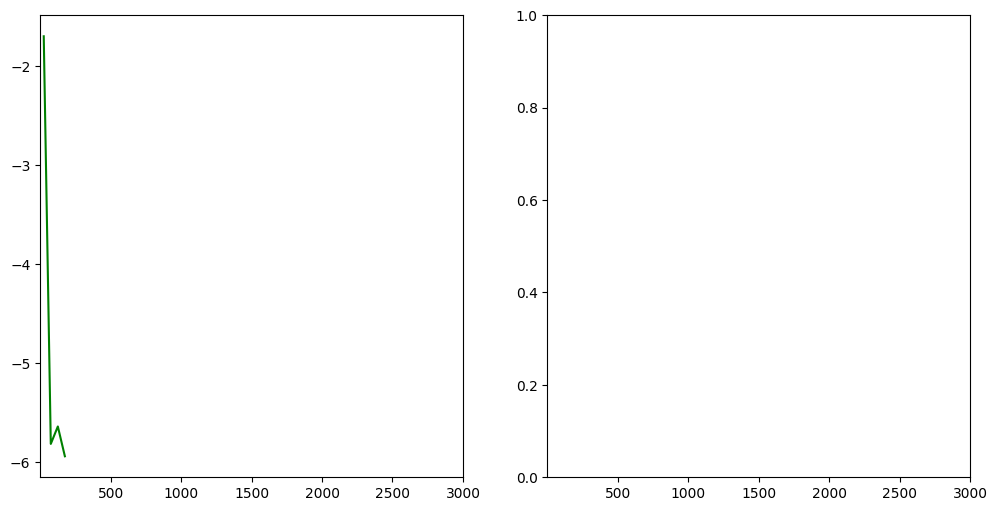

In [453]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
## grid
dmin = 1e-4
dmax = 1e4
dbin = 50
bins = np.arange(dmin, dmax, dbin)

pdf, pdfbins = np.histogram(dg, bins=bins, density=True)
binc = 0.5 * (pdfbins[0:-1] + pdfbins[1:])
print(np.sum(pdf))

pdfpart = []
rinv = 1 / ds
rlog = ds
for left, right in zip(pdfbins[:-1], pdfbins[1:]):
    mask = (rlog > left) & (rlog <= right)
    pdfpart.append(np.sum(rinv[mask]))

pdfpart = (pdfpart / np.sum(rinv)) / dbin
print(np.sum(pdfpart))
#ax[0].plot(binc, np.log10(pdf), color='r', label='regular grid')
#ax[0].plot(binc, np.log10(pdfpart), color='b', label='particle')

# pdf from amr grid

pdf_amr, pdfbins = np.histogram(grid2D_amr, bins=bins, density=True)

ax[0].plot(binc, np.log10(pdf_amr), color='g', )

for i in np.arange(2):
    ax[i].set_xlim(dmin, 3000)
    #ax[i].set_ylim(, 1)

## Resolution effect

In [ ]:
fdir = '/cosma/home/dp004/dc-liu3/data7/sims/swift-rt/YuanKangLiu_snapshots/RadBound_turb/T3e4/'
fname = 'output_Radbound_0047_slice_z_0.498_0.500.hdf5'

snap = swiftsimio.load(os.path.join(fdir, fname))

# cellsize
npixel = 1024
cellsize = (snap.metadata.boxsize / npixel).value[0] # pc
print(cellsize)

# determin z range
zmin = int(0.495 / cellsize)
zmax = int(0.505 / cellsize)
print(int(zmin), int(zmax))

In [458]:
fpath = '/cosma/home/dp004/dc-liu3/data7/sims/swift-rt/YuanKangLiu_snapshots/radmc3d_RadBound_turb_slices/radmc3d_RadBound_turb_dxdydz_maxpart_2'

amr = AMR(fpath=fpath, amr_info_file='amr_grid.inp', verbose=False)

# read all variables
variables = ['T', 'ne', 'nHII', 'nHI']
T_file    = 'gas_temperature_HII.binp'
ne_file   = 'numberdens_elec.binp'
nHII_file = 'numberdens_HII.binp'
nHI_file  = 'numberdens_HI.binp'
data      = {}
for i, (variable, file) in enumerate(zip(variables, [T_file, ne_file, nHII_file, nHI_file])):
    print("reading ", variable, "from file = ", file)
    info = amr.read_amr_var(infile=file, verbose=(i==0))
    data[variable] = info['values']
nH = data['nHI'] + data['nHII']

maxlevel 1
maxlevel 2
maxlevel 3
maxlevel 4
maxlevel 5
maxlevel 6
maxlevel 7
maxlevel 8
maxlevel 9
reading  T from file =  gas_temperature_HII.binp
format = 1, precision=8, nrcells=11145
reading  ne from file =  numberdens_elec.binp
reading  nHII from file =  numberdens_HII.binp
reading  nHI from file =  numberdens_HI.binp


In [459]:
%%time
nHIImesh    = amr.uniform_mesh(amr.read_amr_var(infile=nHII_file, verbose=False))

CPU times: user 7min 54s, sys: 3.4 s, total: 7min 58s
Wall time: 7min 59s


In [460]:
%%time
nHImesh    = amr.uniform_mesh(amr.read_amr_var(infile=nHI_file, verbose=False))

CPU times: user 7min 58s, sys: 3.61 s, total: 8min 2s
Wall time: 8min 3s


In [461]:
nHImesh['variable'][:,:,:].shape

(1024, 1024, 1024)

In [462]:
nHtot = nHImesh['variable'] + nHIImesh['variable']